In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
keras = tf.keras 
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import norm, gaussian_kde, kurtosis
from sklearn.model_selection import train_test_split

from dh_framework import build_dh_model
from dh_loss_functions import VaR, CVaR, entropic
from dh_experiments import MertonJumpDiffusionPrice, set_global_seed, plot_training_curves, residual_error_statistics
from dh_data import generate_jump_diffusion_data

set_global_seed(42)

/Users/rugile/Pricing and Hedging Using Neural Networks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def hill_estimator(prices, k=1000, tail='right'):
    sorted_prices = np.sort(prices)
    if tail == 'right':
        tail_prices = sorted_prices[-k:]
        logs = np.log(tail_prices)-np.log(tail_prices[0])
    else:
        tail_prices = sorted_prices[:k]
        logs = np.log(tail_prices[-1])-np.log(tail_prices)
    return 1.0/np.mean(logs)

# Generate data frames for asset prices using a grid of parameters

In [3]:
import pandas as pd

# Your lists
mu_jumps = [0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.99]
jump_ints = [1, 2, 3, 4, 5, 6, 7, 8, 9]
sigma_jumps = [0.0, 0.01, 0.05, 0.1, 0.25, 0.4, 0.5, 0.75]

# Initialize lists
mu_ = []
int_ = []
sigma_ = []
hills = []

# Loop
for mu_jump in mu_jumps:
    for jump_int in jump_ints:
        for sigma_jump in sigma_jumps:
            x = generate_jump_diffusion_data(
                jump_int=jump_int,
                mu_jump=mu_jump,
                sigma_jump=sigma_jump,
                N=10**5,
                sigma=0.2,
                d=1,
                n=100,
                K=1.0,
                T=1.0,
                S=1.0
            )[0][:, -1, 0]  # Take only S_T
            
            hill = hill_estimator(x)

            mu_.append(mu_jump)
            int_.append(jump_int)
            sigma_.append(sigma_jump)
            hills.append(hill)

# DataFrame
df_hills = pd.DataFrame({
    'mu_jump': mu_,
    'jump_int': int_,
    'sigma_jump': sigma_,
    'hill': hills
})

# Retain values that will be used for training

In [4]:
hills = df_hills.sort_values(by='hill', ascending=True) # Sort from heaviest to lightest right tail
hills = hills.reset_index(drop=True)                    # Reset the index to 0, 1, 2, ...
hills = hills.iloc[:100]                                # Only keep the 100 heaviest tail distributions

# Train deep hedging models using the 100 dataframes with the lowest Hill index estimate

In [5]:
# Initialize columns to store results
mean_tail_errors_var = []
mean_tail_errors_cvar = []

# Define learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Loop over all entries in the hills DataFrame
for idx, row in hills.iterrows():

    print(f'Training models for row {idx+1}/{len(hills)}...')

    # Generate new price paths
    price_paths, payoffs = generate_jump_diffusion_data(
        jump_int=row['jump_int'],
        mu_jump=row['mu_jump'],
        sigma_jump=row['sigma_jump'],
        N=10**5,
        sigma=0.2,
        d=1,
        n=100,
        K=1.0,
        T=1.0,
        S=1.0
    )

    # Train-test split
    xtrain, xtest, ytrain, ytest = train_test_split(
        price_paths, payoffs,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    S_T = xtest[:, -1, 0]
    q95 = np.percentile(S_T, 95)
    mask = S_T > q95

    # VaR 0.05
    keras.backend.clear_session()

    model_var, Premium_Network_var, Hedging_Networks_var = build_dh_model(
        d=1,
        hidden_nodes=16,
        L=5,
        n=100
    )

    model_var.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=VaR(alpha=0.05)
    )

    model_var.fit(
        x=xtrain, y=ytrain,
        epochs=50,
        batch_size=1024,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=False
    )

    hedge_var = model_var.predict(xtest, verbose=0)
    error_var = np.abs(hedge_var[:, 0] - ytest[:, 0])
    mean_tail_error_var = np.mean(error_var[mask])
    mean_tail_errors_var.append(mean_tail_error_var)


    # CVaR 95
    keras.backend.clear_session()

    model_cvar, Premium_Network_cvar, Hedging_Networks_cvar = build_dh_model(
        d=1,
        hidden_nodes=16,
        L=5,
        n=100
    )

    model_cvar.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=CVaR(alpha=0.05)
    )

    model_cvar.fit(
        x=xtrain, y=ytrain,
        epochs=50,
        batch_size=1024,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=False
    )

    hedge_cvar = model_cvar.predict(xtest, verbose=0)
    error_cvar = np.abs(hedge_cvar[:, 0] - ytest[:, 0])
    mean_tail_error_cvar = np.mean(error_cvar[mask])
    mean_tail_errors_cvar.append(mean_tail_error_cvar)

# Add results to DataFrame
hills['mean_tail_error_VaR'] = mean_tail_errors_var
hills['mean_tail_error_CVaR'] = mean_tail_errors_cvar

Training models for row 1/100...
Training models for row 2/100...
Training models for row 3/100...
Training models for row 4/100...
Training models for row 5/100...
Training models for row 6/100...
Training models for row 7/100...
Training models for row 8/100...
Training models for row 9/100...
Training models for row 10/100...
Training models for row 11/100...
Training models for row 12/100...
Training models for row 13/100...
Training models for row 14/100...
Training models for row 15/100...
Training models for row 16/100...
Training models for row 17/100...
Training models for row 18/100...
Training models for row 19/100...
Training models for row 20/100...
Training models for row 21/100...
Training models for row 22/100...
Training models for row 23/100...
Training models for row 24/100...
Training models for row 25/100...
Training models for row 26/100...
Training models for row 27/100...
Training models for row 28/100...
Training models for row 29/100...
Training models for row

## VaR 95% plot

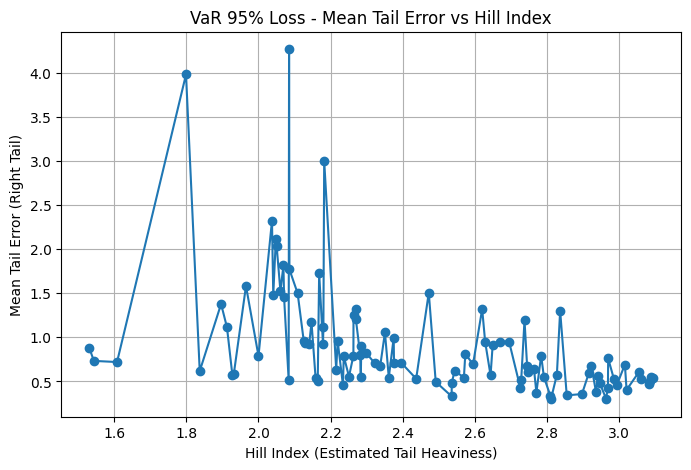

In [6]:
plt.figure(figsize=(8,5))
plt.plot(hills['hill'], hills['mean_tail_error_VaR'], marker='o', linestyle='-')
plt.xlabel('Hill Index (Estimated Tail Heaviness)')
plt.ylabel('Mean Tail Error (Right Tail)')
plt.title('VaR 95% Loss - Mean Tail Error vs Hill Index')
plt.grid(True)
plt.show()

## CVaR 95% plot

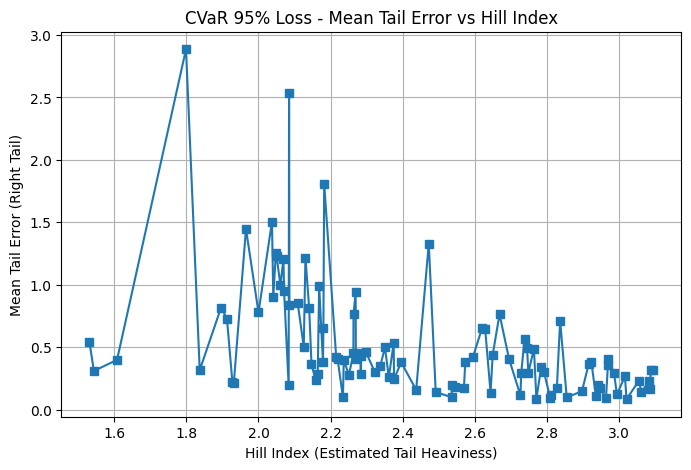

In [7]:
plt.figure(figsize=(8,5))
plt.plot(hills['hill'], hills['mean_tail_error_CVaR'], marker='s', linestyle='-')
plt.xlabel('Hill Index (Estimated Tail Heaviness)')
plt.ylabel('Mean Tail Error (Right Tail)')
plt.title('CVaR 95% Loss - Mean Tail Error vs Hill Index')
plt.grid(True)
plt.show()

## On the same axes

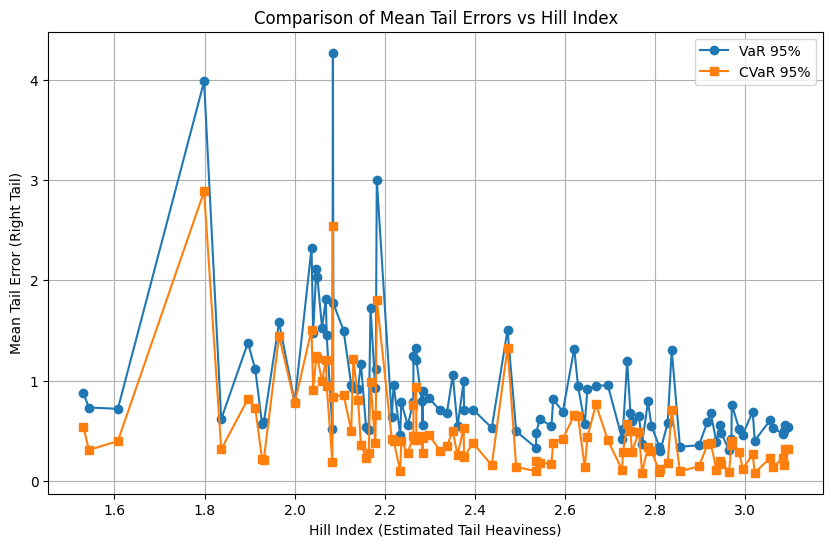

In [8]:
plt.figure(figsize=(10,6))
plt.plot(hills['hill'], hills['mean_tail_error_VaR'], label='VaR 95%', marker='o')
plt.plot(hills['hill'], hills['mean_tail_error_CVaR'], label='CVaR 95%', marker='s')
plt.xlabel('Hill Index (Estimated Tail Heaviness)')
plt.ylabel('Mean Tail Error (Right Tail)')
plt.title('Comparison of Mean Tail Errors vs Hill Index')
plt.grid(True)
plt.legend()
plt.show()

# Smoothed graphs

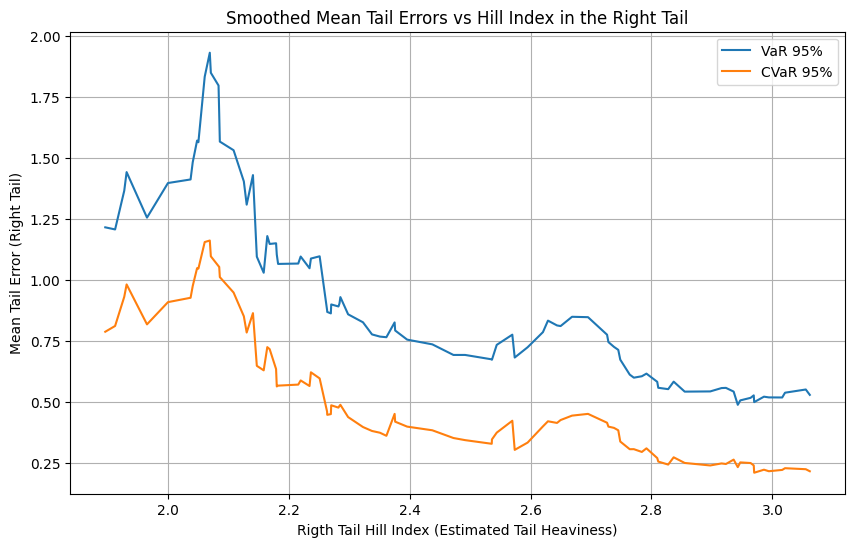

In [31]:
smooth_var = hills['mean_tail_error_VaR'].rolling(10, center=True).mean()
smooth_cvar = hills['mean_tail_error_CVaR'].rolling(10, center=True).mean()

plt.figure(figsize=(10,6))
plt.plot(hills['hill'], smooth_var, label='VaR 95%')
plt.plot(hills['hill'], smooth_cvar, label='CVaR 95%')
plt.xlabel('Rigth Tail Hill Index (Estimated Tail Heaviness)')
plt.ylabel('Mean Tail Error (Right Tail)')
plt.title('Smoothed Mean Tail Errors vs Hill Index in the Right Tail')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
mean_diff = (hills['mean_tail_error_VaR'] - hills['mean_tail_error_CVaR']).mean()
print(f"Mean difference (VaR - CVaR): {mean_diff:.4f}")

Mean difference (VaR - CVaR): 0.4076


In [33]:
summary = pd.DataFrame({
    'VaR 95%': {
        'Mean': hills['mean_tail_error_VaR'].mean(),
        'Min': hills['mean_tail_error_VaR'].min(),
        'Max': hills['mean_tail_error_VaR'].max(),
        'Std': hills['mean_tail_error_VaR'].std()
    },
    'CVaR 95%': {
        'Mean': hills['mean_tail_error_CVaR'].mean(),
        'Min': hills['mean_tail_error_CVaR'].min(),
        'Max': hills['mean_tail_error_CVaR'].max(),
        'Std': hills['mean_tail_error_CVaR'].std()
    },
    'Difference (VaR - CVaR)': {
        'Mean Diff': mean_diff
    }
})

print(summary)

            VaR 95%  CVaR 95%  Difference (VaR - CVaR)
Mean       0.921039  0.513474                      NaN
Min        0.297671  0.082599                      NaN
Max        4.269118  2.886763                      NaN
Std        0.664591  0.478070                      NaN
Mean Diff       NaN       NaN                 0.407566
